In [19]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.nn.functional as F
import cv2
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from pytorchcv.model_provider import get_model as ptcv_get_model # model
import sys, os
import easydict
import torch.backends.cudnn as cudnn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR100
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.optim as optim
import matplotlib.pyplot as plt
#%matplotlib inline 

# enable cuda devices
import os    
os.environ['KMP_DUPLICATE_LIB_OK']='True'

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from meta_neural_network_architectures import VGGReLUNormNetwork, ResNet12
from utils.parser_utils import get_args
from data import MetaLearningSystemDataLoader
from experiment_builder import ExperimentBuilder
from utils import basic
from few_shot_learning_system_attention import MAMLFewShotClassifier
import arbiter

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1. Dataset 구성

In [20]:
# choices=['padding', 'random_patch', 'fixed_patch', arbiter],
method = 'arbiter'

datasets = "mini_imagenet"
# datasets = "tiered_imagenet"
# datasets = "CIFAR_FS"
# datasets = "CUB"

os.environ['DATASET_DIR'] = 'C:/Users/JM/PycharmProjects/MAML/datasets'
# os.environ['TEST_DATASET'] = "tiered_imagenet" # https://mtl.yyliu.net/download/Lmzjm9tX.html
# os.environ['TEST_DATASET'] = "CIFAR_FS" # https://drive.google.com/file/d/1pTsCCMDj45kzFYgrnO67BWVbKs48Q3NI/view
# os.environ['TEST_DATASET'] = "CUB" # https://data.caltech.edu/records/65de6-vp158

In [21]:
os.environ['DATASET_DIR'] = 'C:/Users/JM/PycharmProjects/MAML/datasets'
print("os.environ['DATASET_DIR'] === ", os.environ['DATASET_DIR'])

args = easydict.EasyDict(
{
  "batch_size":2,
  "image_height":84,
  "image_width":84,
  "image_channels":3,
  "gpu_to_use":0,
  "num_dataprovider_workers":4,
  "max_models_to_save":5,
  "dataset_name":"mini_imagenet_full_size",
  "dataset_path":"mini_imagenet_full_size",
  "reset_stored_paths":False,
  "experiment_name":"../MAML_Prompt_task_aware_attention_5way_5shot_filter64_miniImagenet",
  "train_seed": 0, "val_seed": 0,
  "indexes_of_folders_indicating_class": [-3, -2],
  "sets_are_pre_split": True,
  "train_val_test_split": [0.64, 0.16, 0.20],
  "evaluate_on_test_set_only": False,

  "total_epochs": 100,
  "total_iter_per_epoch":500, "continue_from_epoch": -2,
  "num_evaluation_tasks":600,
  "multi_step_loss_num_epochs": 15,
  "minimum_per_task_contribution": 0.01,
  "learnable_per_layer_per_step_inner_loop_learning_rate": True,
  "enable_inner_loop_optimizable_bn_params": False,
  "evalute_on_test_set_only": False,

  "max_pooling": True,
  "per_step_bn_statistics": False,
  "learnable_batch_norm_momentum": False,
  "load_into_memory": False,
  "init_inner_loop_learning_rate": 0.01,
  "init_inner_loop_weight_decay": 0.0005,
  "learnable_bn_gamma": True,
  "learnable_bn_beta": True,

  "dropout_rate_value":0.0,
  "min_learning_rate":0.001,
  "meta_learning_rate":0.001,   "total_epochs_before_pause": 100,
  "first_order_to_second_order_epoch":-1,
  "weight_decay": 0.0,

  "norm_layer":"batch_norm",
  "cnn_num_filters":64,
  "num_stages":4,
  "conv_padding": True,
  "number_of_training_steps_per_iter":5,
  "number_of_evaluation_steps_per_iter":5,
  "cnn_blocks_per_stage":1,
  "num_classes_per_set":5,
  "num_samples_per_class":5,
  "num_target_samples": 15,
  "samples_per_iter" : 1,

  "second_order": True,
  "use_multi_step_loss_optimization":False,
  "backbone": "4-CONV",
  "arbiter": False,
  "use_bias": True,
  "prompter": False,
  "prompt_engineering": 'not',
  "prompt_size" : 10,
  "image_size" : 84,
  "prompt_random_init": False,
  "outer_prompt_learning_rate": 0.001,
  "inner_prompt_learning_rate": 0.01,
  "num_text_embedding_params": 100,
  "text_embedding_learning_rate": 0.01
}
)

device = torch.cuda.current_device()
args.im_shape = (2, 3, args.image_height, args.image_width)

args.use_cuda = torch.cuda.is_available()
args.seed = 104
args.reverse_channels=False
args.labels_as_int=False
args.reset_stored_filepaths=False
args.num_of_gpus=1

args.continue_from_epoch='latest'

os.environ['DATASET_DIR'] ===  C:/Users/JM/PycharmProjects/MAML/datasets


In [22]:
# 모델을 구성한다
model = MAMLFewShotClassifier(args=args, device=device,
                              im_shape=(2, 3,
                                        args.image_height, args.image_width))

data = MetaLearningSystemDataLoader

maml_system = ExperimentBuilder(model=model, data=data, args=args, device=device)
maml_system.state

Using max pooling
meta network params
0.01
Inner Loop parameters
names_learning_rates_dict.layer_dict-conv0-conv-weight torch.Size([6])
names_learning_rates_dict.layer_dict-conv0-conv-bias torch.Size([6])
names_learning_rates_dict.layer_dict-conv1-conv-weight torch.Size([6])
names_learning_rates_dict.layer_dict-conv1-conv-bias torch.Size([6])
names_learning_rates_dict.layer_dict-conv2-conv-weight torch.Size([6])
names_learning_rates_dict.layer_dict-conv2-conv-bias torch.Size([6])
names_learning_rates_dict.layer_dict-conv3-conv-weight torch.Size([6])
names_learning_rates_dict.layer_dict-conv3-conv-bias torch.Size([6])
names_learning_rates_dict.layer_dict-linear-weights torch.Size([6])
names_learning_rates_dict.layer_dict-linear-bias torch.Size([6])
Outer Loop parameters
task_embedding_adaptive_learning_rate torch.Size([6]) cuda:0 True
classifier.layer_dict.conv0.conv.weight torch.Size([64, 3, 3, 3]) cuda:0 True
classifier.layer_dict.conv0.conv.bias torch.Size([64]) cuda:0 True
classifie

{'best_val_acc': 0.0, 'best_val_iter': 0, 'current_iter': 0, 'best_epoch': 0}

# 2. Prompt 설정

x_support_set_task ==  tensor([[[[ 1.1829,  1.1976,  1.1976,  ...,  1.8426,  1.8426,  1.8426],
          [ 1.1829,  1.1976,  1.1976,  ...,  1.8426,  1.8426,  1.8426],
          [ 1.1829,  1.1976,  1.2122,  ...,  1.8426,  1.8426,  1.8426],
          ...,
          [-0.2538, -0.2245, -0.1658,  ...,  1.8133,  1.8133,  1.8133],
          [-0.2978, -0.2684, -0.2245,  ...,  1.7986,  1.7986,  1.7986],
          [-0.3417, -0.3271, -0.2684,  ...,  1.7840,  1.7840,  1.7840]],

         [[ 1.1987,  1.2140,  1.2292,  ...,  2.0090,  2.0090,  2.0090],
          [ 1.1987,  1.2140,  1.2292,  ...,  2.0090,  2.0090,  2.0090],
          [ 1.1987,  1.2140,  1.2292,  ...,  2.0090,  2.0090,  2.0090],
          ...,
          [-1.1405, -1.1099, -1.0488,  ...,  1.8714,  1.8714,  1.8714],
          [-1.1864, -1.1405, -1.1099,  ...,  1.8561,  1.8561,  1.8561],
          [-1.2170, -1.1864, -1.1405,  ...,  1.8408,  1.8408,  1.8408]],

         [[ 1.0879,  1.1021,  1.1163,  ...,  1.9969,  2.0254,  2.0254],
       

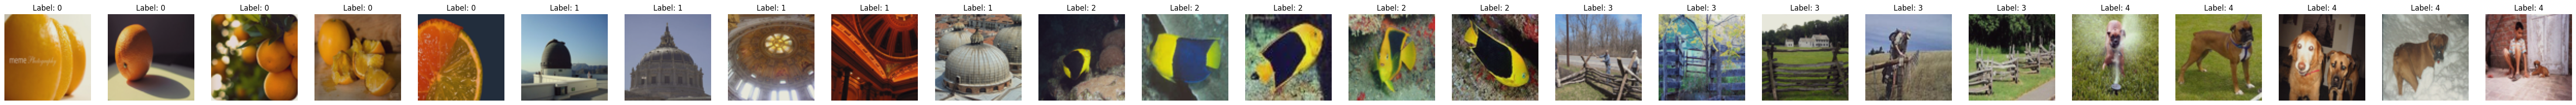

ideal_prompt ==  tensor([[[[-3.8300e-05, -1.0967e-05, -1.1391e-05,  ..., -2.3185e-05,
           -2.3263e-05, -2.5834e-05],
          [-4.0941e-05, -6.1736e-05, -6.4095e-05,  ..., -1.8559e-04,
           -1.8537e-04, -1.3099e-04],
          [-4.1438e-05, -6.1410e-05, -5.7712e-05,  ..., -1.8559e-04,
           -1.8537e-04, -1.3099e-04],
          ...,
          [ 3.3258e-05,  1.3456e-05,  1.3584e-05,  ..., -1.5853e-04,
           -1.5603e-04, -1.3433e-04],
          [ 3.3319e-05,  1.3696e-05,  1.3812e-05,  ..., -1.5423e-04,
           -1.5411e-04, -1.3338e-04],
          [ 7.8529e-06, -2.2446e-06, -1.7932e-06,  ..., -9.9922e-06,
           -6.0055e-06, -4.3591e-05]],

         [[ 5.5697e-05,  1.3018e-04,  1.3137e-04,  ...,  2.3119e-04,
            2.3286e-04,  1.7464e-04],
          [ 7.6108e-05,  2.1754e-04,  2.2424e-04,  ...,  6.2316e-04,
            6.2908e-04,  4.4075e-04],
          [ 7.5610e-05,  2.1482e-04,  2.1680e-04,  ...,  6.2316e-04,
            6.2908e-04,  4.4075e-04],
   

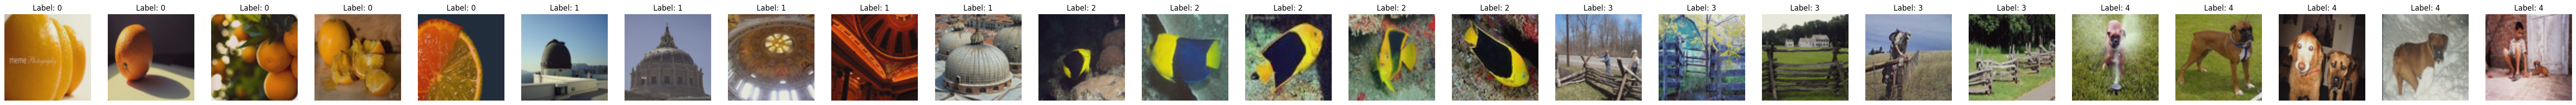

ideal_prompt ==  tensor([[[[-3.8303e-05, -1.0970e-05, -1.1399e-05,  ..., -2.3209e-05,
           -2.3287e-05, -2.5850e-05],
          [-4.0945e-05, -6.1741e-05, -6.4106e-05,  ..., -1.8566e-04,
           -1.8543e-04, -1.3102e-04],
          [-4.1442e-05, -6.1413e-05, -5.7708e-05,  ..., -1.8559e-04,
           -1.8536e-04, -1.3098e-04],
          ...,
          [ 3.3260e-05,  1.3456e-05,  1.3585e-05,  ..., -1.5854e-04,
           -1.5603e-04, -1.3432e-04],
          [ 3.3321e-05,  1.3697e-05,  1.3813e-05,  ..., -1.5424e-04,
           -1.5413e-04, -1.3340e-04],
          [ 7.8526e-06, -2.2450e-06, -1.7937e-06,  ..., -9.9273e-06,
           -5.9514e-06, -4.3561e-05]],

         [[ 5.5698e-05,  1.3018e-04,  1.3138e-04,  ...,  2.3120e-04,
            2.3287e-04,  1.7466e-04],
          [ 7.6110e-05,  2.1755e-04,  2.2426e-04,  ...,  6.2321e-04,
            6.2912e-04,  4.4076e-04],
          [ 7.5609e-05,  2.1481e-04,  2.1680e-04,  ...,  6.2309e-04,
            6.2902e-04,  4.4073e-04],
   

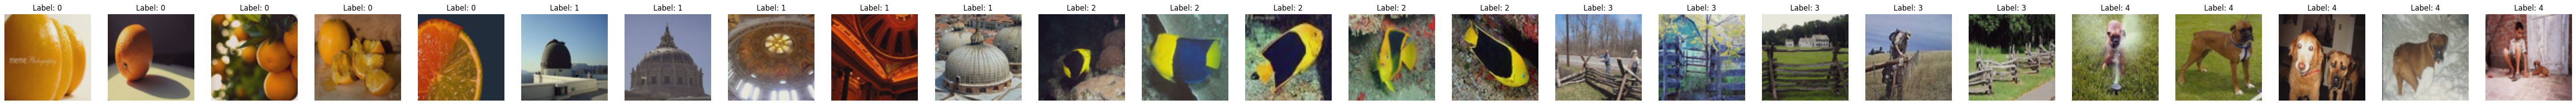

ideal_prompt ==  tensor([[[[-3.8305e-05, -1.0974e-05, -1.1406e-05,  ..., -2.3233e-05,
           -2.3311e-05, -2.5866e-05],
          [-4.0948e-05, -6.1746e-05, -6.4117e-05,  ..., -1.8573e-04,
           -1.8549e-04, -1.3104e-04],
          [-4.1445e-05, -6.1416e-05, -5.7704e-05,  ..., -1.8560e-04,
           -1.8536e-04, -1.3096e-04],
          ...,
          [ 3.3261e-05,  1.3457e-05,  1.3586e-05,  ..., -1.5854e-04,
           -1.5603e-04, -1.3430e-04],
          [ 3.3322e-05,  1.3698e-05,  1.3814e-05,  ..., -1.5426e-04,
           -1.5415e-04, -1.3342e-04],
          [ 7.8524e-06, -2.2455e-06, -1.7942e-06,  ..., -9.8624e-06,
           -5.8973e-06, -4.3530e-05]],

         [[ 5.5699e-05,  1.3018e-04,  1.3139e-04,  ...,  2.3121e-04,
            2.3289e-04,  1.7469e-04],
          [ 7.6113e-05,  2.1756e-04,  2.2427e-04,  ...,  6.2326e-04,
            6.2916e-04,  4.4078e-04],
          [ 7.5608e-05,  2.1481e-04,  2.1680e-04,  ...,  6.2303e-04,
            6.2896e-04,  4.4071e-04],
   

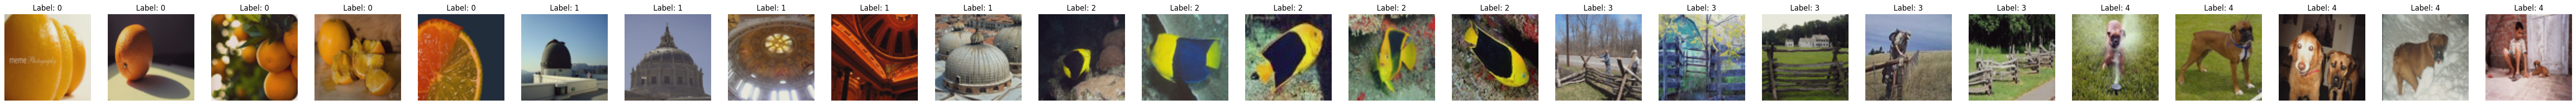

ideal_prompt ==  tensor([[[[-3.8308e-05, -1.0977e-05, -1.1414e-05,  ..., -2.3257e-05,
           -2.3334e-05, -2.5881e-05],
          [-4.0952e-05, -6.1751e-05, -6.4128e-05,  ..., -1.8579e-04,
           -1.8555e-04, -1.3107e-04],
          [-4.1449e-05, -6.1419e-05, -5.7700e-05,  ..., -1.8560e-04,
           -1.8535e-04, -1.3095e-04],
          ...,
          [ 3.3262e-05,  1.3458e-05,  1.3587e-05,  ..., -1.5854e-04,
           -1.5603e-04, -1.3429e-04],
          [ 3.3323e-05,  1.3698e-05,  1.3815e-05,  ..., -1.5427e-04,
           -1.5417e-04, -1.3344e-04],
          [ 7.8522e-06, -2.2459e-06, -1.7947e-06,  ..., -9.7975e-06,
           -5.8432e-06, -4.3500e-05]],

         [[ 5.5700e-05,  1.3018e-04,  1.3140e-04,  ...,  2.3122e-04,
            2.3290e-04,  1.7471e-04],
          [ 7.6116e-05,  2.1757e-04,  2.2429e-04,  ...,  6.2331e-04,
            6.2919e-04,  4.4080e-04],
          [ 7.5607e-05,  2.1481e-04,  2.1679e-04,  ...,  6.2297e-04,
            6.2890e-04,  4.4069e-04],
   

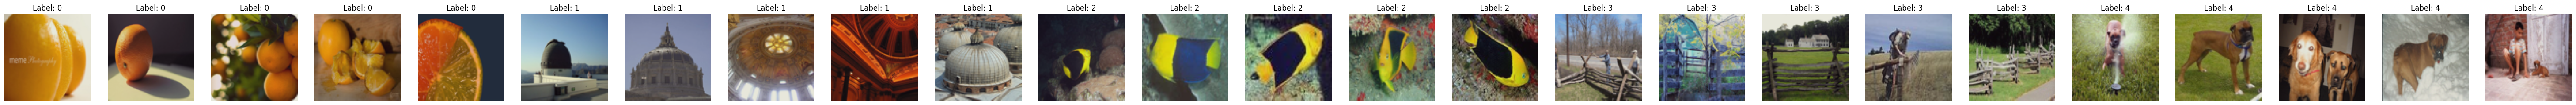

ideal_prompt ==  tensor([[[[-3.8310e-05, -1.0980e-05, -1.1421e-05,  ..., -2.3281e-05,
           -2.3358e-05, -2.5897e-05],
          [-4.0955e-05, -6.1756e-05, -6.4139e-05,  ..., -1.8586e-04,
           -1.8561e-04, -1.3110e-04],
          [-4.1452e-05, -6.1421e-05, -5.7696e-05,  ..., -1.8561e-04,
           -1.8534e-04, -1.3094e-04],
          ...,
          [ 3.3263e-05,  1.3458e-05,  1.3588e-05,  ..., -1.5854e-04,
           -1.5602e-04, -1.3428e-04],
          [ 3.3325e-05,  1.3699e-05,  1.3816e-05,  ..., -1.5429e-04,
           -1.5419e-04, -1.3345e-04],
          [ 7.8520e-06, -2.2464e-06, -1.7952e-06,  ..., -9.7326e-06,
           -5.7892e-06, -4.3470e-05]],

         [[ 5.5701e-05,  1.3018e-04,  1.3141e-04,  ...,  2.3122e-04,
            2.3292e-04,  1.7473e-04],
          [ 7.6118e-05,  2.1757e-04,  2.2430e-04,  ...,  6.2337e-04,
            6.2923e-04,  4.4082e-04],
          [ 7.5607e-05,  2.1480e-04,  2.1679e-04,  ...,  6.2291e-04,
            6.2883e-04,  4.4066e-04],
   

KeyboardInterrupt: 

In [28]:
train_data = maml_system.data.get_train_batches(total_batches=int(600/1), augment_images=False)

for sample_idx, train_sample in enumerate(train_data):
    
    x_support_set, x_target_set, y_support_set, y_target_set, seed = train_sample
    
    x_support_set = torch.Tensor(x_support_set).float().to(device=maml_system.model.device)
    x_target_set = torch.Tensor(x_target_set).float().to(device=maml_system.model.device)
    y_support_set = torch.Tensor(y_support_set).long().to(device=maml_system.model.device)
    y_target_set = torch.Tensor(y_target_set).long().to(device=maml_system.model.device)
    
    for task_id, (x_support_set_task, y_support_set_task, x_target_set_task, y_target_set_task) in enumerate(zip(x_support_set,
                              y_support_set,
                              x_target_set,
                              y_target_set)):
        
        
        names_weights_copy = maml_system.model.get_inner_loop_parameter_dict(maml_system.model.classifier.named_parameters())

        num_devices = torch.cuda.device_count() if torch.cuda.is_available() else 1

        names_weights_copy = {
            name.replace('module.', ''): value.unsqueeze(0).repeat(
                [num_devices] + [1 for i in range(len(value.shape))]) for
            name, value in names_weights_copy.items()}
        

        names_weights_copy = {key: value for key, value in names_weights_copy.items() if 'layer_dict' in key}
        
        
        n, s, c, h, w = x_target_set_task.shape

        x_support_set_task = x_support_set_task.view(-1, c, h, w)
        y_support_set_task = y_support_set_task.view(-1)
        x_target_set_task = x_target_set_task.view(-1, c, h, w)
        y_target_set_task = y_target_set_task.view(-1)
        
    
        z = nn.Parameter(torch.ones([1, args.num_text_embedding_params]), requires_grad=True).to(maml_system.model.device)
        # z = torch.zeros(size=[1, self.args.num_text_embedding_params], requires_grad=True).to(self.device)
        
        print("x_support_set_task == ", x_support_set_task)
        
        for num_step in range(5):
            
            ideal_prompt = maml_system.model.arbiter(x_support_set_task, z)
            x_support_set_task = x_support_set_task + ideal_prompt
            
            support_loss, support_preds, _ = maml_system.model.net_forward(
              x=x_support_set_task,
              y=y_support_set_task,
              weights=names_weights_copy,
              backup_running_statistics=num_step == 0,
              training=True,
              num_step=num_step,
              training_phase=False,
              epoch=0)
            
            
            gradients = torch.autograd.grad(support_loss, (*names_weights_copy.values(), z), create_graph=True, retain_graph=True)

            grads, context_grads = gradients[:-1], gradients[-1]

            if args.learnable_per_layer_per_step_inner_loop_learning_rate:
                z = z - maml_system.model.task_embedding_adaptive_learning_rate[num_step] * context_grads
            else:
                z = z - maml_system.model.args.text_embedding_learning_rate * context_grads

            
            names_weights_copy = maml_system.model.apply_inner_loop_update(
             loss=support_loss,
             names_weights_copy=names_weights_copy,
             use_second_order=True,
             current_step_idx=num_step,
             current_iter='test',
             training_phase=False)
            
            print("num_step == ", num_step)
            basic.show_batch(images=x_support_set_task, labels=y_support_set_task, datasets=datasets)
#             print("ideal_prompt.shape == ", ideal_prompt.shape)
            print("ideal_prompt == ", ideal_prompt)
            
#             print("Jupyter notebook !!!")
#             print("x_support_set_task == ")
#             print(x_support_set_task[0])
#             print(x_support_set_task.shape)
#             print("ideal_prompt == ")
#             print(ideal_prompt)
#             print(ideal_prompt.shape)
#             print("prompted_images == ")
#             print(prompted_images.shape)
#             print(prompted_images[0])
            
            if num_step == 4:
                
                print("num_step == ", num_step)
                
                ideal_prompt = maml_system.model.arbiter(x_target_set_task, z)
                x_target_set_task = x_target_set_task + ideal_prompt 
                
                basic.show_batch(images=x_target_set_task, labels=y_target_set_task, datasets=datasets)
                
                target_loss, target_preds, prompt_feature_map = maml_system.model.net_forward(
                    x=x_target_set_task,
                    y=y_target_set_task,
                    weights=names_weights_copy,
                    backup_running_statistics=False, training=True,
                    num_step=num_step,
                    training_phase=False,
                    epoch=0)
                
                
        
        